# Final Report Notebook

Here you will find a complete summary of my work for this project--this will include all of the code required to reproduce this project, as well as detailed descriptions and motivations for each step taken.

First we will make the necessary imports:

In [13]:
# General purpose
import pandas as pd
import matplotlib.pyplot as plt

# Visualization formatting
plt.rcParams['font.size'] = 24
plt.style.use('fivethirtyeight')

# Natural language processing


# Modeling



## Data Acquisition

#### VGChartz

The data in this project came from a few sources. First, we'll start with the scraped data from the video game database [VGChartz](https://www.vgchartz.com/).

The actual scraping work can be found in the exploratory notebook [Initial Web Scraping](../notebooks/01_explore_scrape.ipynb).

Below we will import the resulting data:

In [2]:
df = pd.read_csv('../data/nice_data.csv', low_memory=False)
df.shape

(16719, 16)

We end up with a ton of entries! Let's see how they look

In [3]:
df.sample(3)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
1765,Medal of Honor: Warfighter,X360,2012.0,Action,Electronic Arts,0.59,0.45,0.01,0.1,1.15,53.0,43.0,5.4,437.0,Danger Close,M
13578,Justice League: Chronicles,GBA,2003.0,Platform,Midway Games,0.03,0.01,0.00,0.0,0.04,43.0,7.0,tbd,NaN,Full-Fat,E
10666,Evil Dead: Fistfull of Boomstick,XB,2003.0,Action,THQ,0.07,0.02,0.00,0.0,0.10,NaN,NaN,NaN,NaN,NaN,NaN


Alright, we have a lot of missing data here. We're most interested in the 'critic_score' column, so let's see how many entries are present

In [4]:
scores = df[df.Critic_Score.isna() == False].shape
print(f'{scores[0]} out of {df.shape[0]} possible critic scores are present')

8137 out of 16719 possible critic scores are present


Not too great, a majority of our entries have no critic score values--those will need to be dropped. However, we are still left with over 8,000 games, so we'll take them to the next step

#### Wikipedia

For the next step in acquiring the data, we turn to the Wikipedia API. Using the available python library, getting Wikipedia information is extremely easy. This is good for us, because we will need to make a lot of requests. 

To use the API, you supply the name of the relevant Wikipedia page, and it will return the text of any section you would like. So we send in all of our game titles, along with some variations on them, and we got back most of our entries.

We'll import the resulting data below, but the full work can be found in the [Wikiscraping Notebook](../notebooks/02_wikiscraping.ipynb)

In [5]:
df = pd.read_csv('../data/final_plots.csv').drop('Unnamed: 0', axis=1)
df.shape

(5143, 17)

Now we have 5,143 entries with full Wikipedia descriptions and critic scores

Let's see one of these descriptions

In [6]:
print(df.plots.sample(random_state=2).values[0])

Master of Illusion puts the player in the role of an illusionist who must learn and perfect his tricks. The game has three basic modes: Solo Magic, Magic Show and Magic Training. The first one is a compilation of varied minigames, the other two being the "meat of the game", or the important part, according to reviewers. In both, the objective is to perform tricks and earn points, which grant the player more tricks and illusions. The system has a limit for the points a player can earn in a full day, though this can be bypassed by changing the date on the Nintendo DS system.


## Data Understanding

A couple things to note about the game descriptions:
- We're getting our descriptions directly from Wikipedia, we don't have to deal with too many errors in our corpus (e.g. spelling, grammar)
- Some of these entries are plot synopses, and some of them are gameplay descriptions. It appears to depend on the type of game.

Now we have all the data we will need, let's take a look at a complete sample entry and examine the columns:

In [7]:
df.sample(random_state=3)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
2825,Risen 2: Dark Waters,PS3,2012.0,Role-Playing,Deep Silver,0.04,0.13,0.01,0.04,0.22,47.0,13.0,5.2,37.0,Piranha Bytes,M,The story begins in the Fortress of Crystal at...



**Name**

- The official title of the game at release

**Platform**

- The game system this title was released for: uses the standard abbreviations for each system (e.g. PS3 = Playstation 3, GC = Nintendo GameCube)

**Year of Release**

- The original year the game was released in. This seems to be the earliest year if the release was staggered across regions

**Genre**

- A single genre designation for the game. These are very simple classifications like 'shooter' or 'role-playing'

**Developer**

- The name of the studio responsible for making the game: programming the game, creating the artwork, etc.

**Publisher**

- The name of the company that sells and distributes the game


**NA/EU/JP/Other/Global Sales**

- The number of *units* sold in millions, in each particular region. The global sales figure is the sum of the other four categories

**Critic Score/Critic Count**

- The average of the verified critic scores from Metacritic (these range from 0.0-100.0), as well as the number of reviews that make up that figure. At minimum the score is an average of 3 reviews

**User Score/User Count**

- The average user score on Metacritic (10 point scale), as well as the number of reviews. At minimum there are 4 scores for each game

**Rating**

- The ESRB rating of the game: this can be one of E, E10+, T, M, AO, or K-A

Let's check out the distribution of our critic review scores:

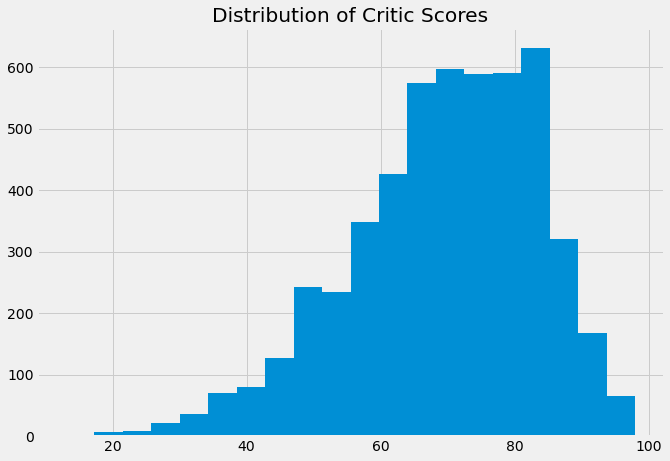

In [36]:
df.Critic_Score.hist(figsize=(10,7), bins=20)
plt.title('Distribution of Critic Scores');

In my experience, this is a typical distribution for ratings: left-skewed with the median around 70%. Let's get our data cleaned up.

## Data Cleaning

The first step I will take is getting the critic scores binned. I would like to make targeting the critic scores a classification rather than a regression problem for the following reason: It's not that meaningful to try to predict what *exact score* a game will recieve. No matter the amount of score averaging, the assigned critic sccore will still have some degree of arbitrariness. More generally I think we care about whether a game receives high, average, or low scores. For this reason I will be grouping the scores in the following three groups:

| Designation | Class | Score Range | 
|:-------------:|:-------:|:-------------:|
|     High    |   2   |  (75,100]  |  
|   Average   |   1   |   (60,75]   |   
|     Low     |   0   |    [0,60]   |   

We will use the following function to do so:

In [35]:
def bin_scores(score):
    if score > 60:
        if score > 75:
            return 2
        return 1
    return 0

df['success'] = df['Critic_Score'].apply(bin_scores)

Let's quickly make sure that we have a decent class balance

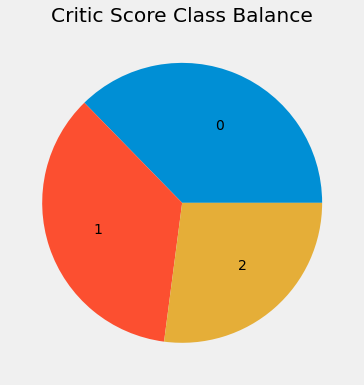

In [34]:
plt.figure(figsize=(6,6))
plt.pie(df.success.value_counts(), labels=[0,1,2], labeldistance=.6)
plt.title('Critic Score Class Balance');

Perfect, our classes both have balance and their designations align with how people generally think of critical reception